In [1]:
# 2023 Gabriel J. Diaz @ RIT

import os
import sys
import numpy as np

import logging
import pickle
from tqdm import tqdm

import scipy.signal as signal

import io
from PIL import Image

import matplotlib.pyplot as plt
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from pathlib import Path, PurePath

import sys
sys.path.append('../..')
from flow_source import *

logger = logging.getLogger(__name__)
logger.addHandler(logging.StreamHandler(stream=sys.stdout))

In [2]:
plt.rcParams['figure.figsize'] = [640/50., 480 /50.]

In [3]:
# a_file_path = Path(os.path.join('..','..','pupil_labs_data','GD-Short-Driving-Video'))
a_file_path = Path(os.path.join('..','..','pupil_labs_data','cb13'))
a_file_path
source = pupil_labs_source(a_file_path)

In [4]:
p = r'/Users/gjdpci/Documents/GitHub/retinal_flow_toolkit/cb13_world_nvidia2_hsv_overlay.mp4'
source.set_video_target(Path(p).as_uri())

True

In [5]:
video = cv2.VideoCapture(source.video_target_path)

In [6]:
start_frame = 9023
end_frame = 9432

from collections import deque
video.set(cv2.CAP_PROP_POS_FRAMES, start_frame)

buffer_len = 30

frame = 9023
flow_buffer = deque([] * 20)

In [7]:
combined_flow = np.sum(flow_buffer,axis=0)
np.shape(combined_flow)

()

In [8]:
def crop_image(bgr_image,win_size):
    
    # crops off the bad OF estimation from the outer parts of the image
    h = np.shape(bgr_image)[0]
    w = np.shape(bgr_image)[1]

    # width of analysis window in proportions of image width/height

    b = int(h/2 + (win_size*h)/2)
    t = int(h/2 - (win_size*h)/2)
    l = int(w/2 - (win_size*w)/2)
    r = int(w/2 + (win_size*w)/2)

    sm_image = bgr_image[t:b,l:r,:]

    return sm_image

def crop_div(div_image,win_size):
    
    # crops off the bad OF estimation from the outer parts of the image
    h = np.shape(div_image)[0]
    w = np.shape(div_image)[1]

    # width of analysis window in proportions of image width/height

    b = int(h/2 + (win_size*h)/2)
    t = int(h/2 - (win_size*h)/2)
    l = int(w/2 - (win_size*w)/2)
    r = int(w/2 + (win_size*w)/2)

    sm_image = div_image[t:b,l:r]

    return sm_image

def plot_flow_overlay(image_in, flow_in, crop_to=0.8, skippts=5):
    
    if crop_to:
        image_in = crop_image(image_in,crop_to)
        flow_in = crop_image(flow_in,crop_to)
    
    xmax=np.shape(image_in)[1]
    xpoints = int(np.shape(image_in)[1])
    x=np.linspace(0,np.shape(image_in)[1],xmax)

    ymax=np.shape(image_in)[0]
    ypoints = int(np.shape(image_in)[0])
    y=np.linspace(0,np.shape(image_in)[0],ymax)

    x2d,y2d=np.meshgrid(x,y,indexing='xy')

    u = flow_in[...,0]
    v = flow_in[...,1]

#     plt.figure()
    fig, ax = plt.subplots()
    plt.imshow(cv2.cvtColor(image_in, cv2.COLOR_BGR2RGB))
    ax.axis('off') 
    
    if skippts:
        skip=(slice(None,None,skippts),slice(None,None,skippts)) #don't plot all the point as this get too messy
#         plt.quiver(x2d[skip], y2d[skip],u[skip],v[skip],color='white',alpha=0.5)
        plt.quiver(x2d[skip], y2d[skip],u[skip],v[skip],color='white', alpha=0.7, width=.008)
    else:
        plt.quiver(x2d,y2d, u, v, color='white',alpha=0.5)

# def calc_div_curl(image_in):

#     u = image_in[...,0]
#     v = image_in[...,1]

#     xmax=np.shape(image_in)[1]
#     xpoints = int(np.shape(image_in)[1])
#     x=np.linspace(0,np.shape(image_in)[1],xmax)

#     ymax=np.shape(image_in)[0]
#     ypoints = int(np.shape(image_in)[0])
#     y=np.linspace(0,np.shape(image_in)[0],ymax)

#     #discrete numerical approximation to divergence and curl operator
#     #we express that divergence equals the flux out of a pixel
#     #this may not be the most elegant or accurate way
#     kerndx=np.array([[0,0,0],[1, 0, -1],[0,0,0]]) #strange sign convention?
#     kerndy=np.array([[0,1,0],[0, 0, 0],[0,-1,0]])

#     dx=(x[2]-x[0])
#     dy=(y[2]-y[0])

#     dudx=signal.convolve(u,kerndx,mode='same')/dx
#     dvdy=signal.convolve(v,kerndy,mode='same')/dy

#     div=dudx+dvdy

#     s2=np.sqrt(2.0)
#     dudy=signal.convolve(u,kerndy,mode='same')/dy
#     dvdx=signal.convolve(v,kerndx,mode='same')/dx
#     curl=dvdx-dudy
    
#     return div, curl  


In [9]:
def calc_div_curl(image_in):

    v = image_in[...,0]
    u = image_in[...,1]

    xmax=np.shape(image_in)[1]
    xpoints = int(np.shape(image_in)[1])
    x=np.linspace(0,np.shape(image_in)[1],xmax)

    ymax=np.shape(image_in)[0]
    ypoints = int(np.shape(image_in)[0])
    y=np.linspace(0,np.shape(image_in)[0],ymax)

    #discrete numerical approximation to divergence and curl operator
    #we express that divergence equals the flux out of a pixel
    #this may not be the most elegant or accurate way
    kerndx=np.array([[0,0,0],[1, 0, -1],[0,0,0]]) #strange sign convention?
    kerndy=np.array([[0,1,0],[0, 0, 0],[0,-1,0]])

    dx=(x[2]-x[0])
    dy=(y[2]-y[0])

    dudx=signal.convolve(u,kerndx,mode='same')/dx
    dvdy=signal.convolve(v,kerndy,mode='same')/dy

    div=dudx+dvdy

    s2=np.sqrt(2.0)
    dudy=signal.convolve(u,kerndy,mode='same')/dy
    dvdx=signal.convolve(v,kerndx,mode='same')/dx
    curl=dvdx-dudy
    
    return div, curl  



# def divcurl(u,v,xaxis,yaxis):
#     #discrete numerical approximation to divergence and curl operator
#     #we express that divergence equals the flux out of a pixel
#     #this may not be the most elegant or accurate way
#     kerndx=np.array([[0,0,0],[1, 0, -1],[0,0,0]]) #strange sign convention?
#     kerndy=np.array([[0,1,0],[0, 0, 0],[0,-1,0]])
#     dx=(xaxis[2]-xaxis[0])
#     dy=(yaxis[2]-yaxis[0])
#     dudx=signal.convolve(u,kerndx,mode='same')/dx
#     dvdy=signal.convolve(v,kerndy,mode='same')/dy
#     div=dudx+dvdy
#     s2=np.sqrt(2.0)
#     #kerncurlx=np.array([[-s2,-1,-s2],[0, 0, 0],[s2,1,s2]])
#     #kerncurly=np.array([[-s2,0,s2],[1, 0, 1],[-s2,1,s2]])
#     dudy=signal.convolve(u,kerndy,mode='same')/dy
#     dvdx=signal.convolve(v,kerndx,mode='same')/dx
#     curlz=dvdx-dudy
#     return div,curlz
# divergence,curlz=divcurl(u,v,x,y)

In [10]:
import numpy as np
import math
import copy

def scale_values(array: np.ndarray, scalar: float, max_value: float) -> np.ndarray:
    
    """Scales an array's values based on their distance from a maximum value.
    
    Args:
        array (np.ndarray): Input array.
        max_value (float): Maximum value for scaling purposes.

    Returns:
        np.ndarray: Scaled array.
    """
    array_in = copy.deepcopy(array)
    idx = array_in<max_value
    
    scaled_array = copy.deepcopy(array_in[idx])
    diff_pct = (max_value - scaled_array) / max_value
    scaled_array = scaled_array ** (1 + scalar)
    array_in[idx] = scaled_array
    
    return array_in.astype(np.uint8)


In [307]:
def visualize_flow_as_vectors(frame, flow, divisor=15, vector_scalar = 1, crop_to = 1.0,thickness = 3, tipLength = 0.35):

        '''Display image with a visualisation of a flow over the top.
        A divisor controls the density of the quiver plot.'''

        # create a blank mask, on which lines will be drawn.
        mask = np.zeros([np.shape(frame)[0], np.shape(frame)[1], 3], np.uint8)
        
        if crop_to:
            frame = crop_image(frame,crop_to)
            flow = crop_image(flow,crop_to)
    
        xmax=np.shape(frame)[1]
        xpoints = int(np.shape(frame)[1])
        x=np.linspace(0,np.shape(frame)[1],xmax)

        ymax=np.shape(frame)[0]
        ypoints = int(np.shape(frame)[0])
        y=np.linspace(0,np.shape(frame)[0],ymax)

        x2d,y2d=np.meshgrid(x,y,indexing='xy')

        endpoints_x = flow[...,0]
        endpoints_y = flow[...,1]
        
#         if vector_scalar != 1 & vector_scalar != False:
#             magnitude = np.multiply(magnitude, vector_scalar)

        for r in range(1, int(np.shape(frame)[0] / divisor)):
            for c in range(1, int(np.shape(frame)[1] / divisor)):

                origin_x = c * divisor
                origin_y = r * divisor

                endpoint_x = endpoints_x[origin_y, origin_x].astype(np.uint8)
                endpoint_y = endpoints_y[origin_y, origin_x].astype(np.uint8)

                mask = cv2.arrowedLine(mask, (origin_x, origin_y), (endpoint_x,endpoint_y),color=(0, 0, 255), 
                                       thickness = thickness, tipLength = tipLength)


        return cv2.addWeighted(frame, 0.5, mask, 0.5, 0)
    
    # def visualize_flow_as_vectors(frame, flow, divisor=15, vector_scalar = 1, crop_to = 1.0,thickness = 3, tipLength = 0.35):

#         '''Display image with a visualisation of a flow over the top.
#         A divisor controls the density of the quiver plot.'''

#         # create a blank mask, on which lines will be drawn.
#         mask = np.zeros([np.shape(frame)[0], np.shape(frame)[1], 3], np.uint8)
        
#         if crop_to:
#             frame = crop_image(frame,crop_to)
#             flow = crop_image(flow,crop_to)
    
#         xmax=np.shape(frame)[1]
#         xpoints = int(np.shape(frame)[1])
#         x=np.linspace(0,np.shape(frame)[1],xmax)

#         ymax=np.shape(frame)[0]
#         ypoints = int(np.shape(frame)[0])
#         y=np.linspace(0,np.shape(frame)[0],ymax)

# #         x2d,y2d=np.meshgrid(x,y,indexing='xy')

#         endpoints_x = flow[...,0]
#         endpoints_y = flow[...,1]
        
# #         if vector_scalar != 1 & vector_scalar != False:
# #             magnitude = np.multiply(magnitude, vector_scalar)

#         for r in range(1, int(np.shape(frame)[0] / divisor)):
#             for c in range(1, int(np.shape(frame)[1] / divisor)):

#                 origin_x = c * divisor
#                 origin_y = r * divisor

#                 endpoint_x = endpoints_x[origin_y, origin_x].astype(np.uint8)
#                 endpoint_y = endpoints_y[origin_y, origin_x].astype(np.uint8)

#                 mask = cv2.arrowedLine(mask, (origin_x, origin_y), (endpoint_x,endpoint_y),color=(0, 0, 255), 
#                                        thickness = thickness, tipLength = tipLength)


#         return cv2.addWeighted(frame, 0.5, mask, 0.5, 0)

In [308]:
frame = 9020
video.set(cv2.CAP_PROP_POS_FRAMES, frame)

# 27850
buffer_len = 5

flow_buffer = deque([] * buffer_len)
div_time = []

flow = np.zeros([np.shape(image)[0],np.shape(image)[1],2])

success = True
while success:
    
    success, image = video.read()
    
#     if success:
        
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    mag = hsv[...,2]

    angle = (hsv[..., 0] * np.pi * 2.0) / 180.0 # angles are in radians here

    u = mag * np.cos(angle) * mag * -1 # this is the same as flow[...,0] * mag * -1, as I did above
    v = mag  * np.sin(angle) * mag

    flow = np.zeros([np.shape(image)[0],np.shape(image)[1],2])

    flow[...,0] = u
    flow[...,1] = v

    flow_buffer.appendleft(flow)
        
    frame = frame + 1
    
    combined_flow = np.sum(flow_buffer,axis=0)
    combined_flow = cv2.blur(combined_flow,[7,7])
    
    div, curl = calc_div_curl(combined_flow)
    div_time.append( div[int(np.shape(div)[0]/2), int(np.shape(div)[1]/2)] ) 
    
    if frame >= start_frame + buffer_len:
        success = False
        
    if frame >= end_frame:
        success = False

# print(count)

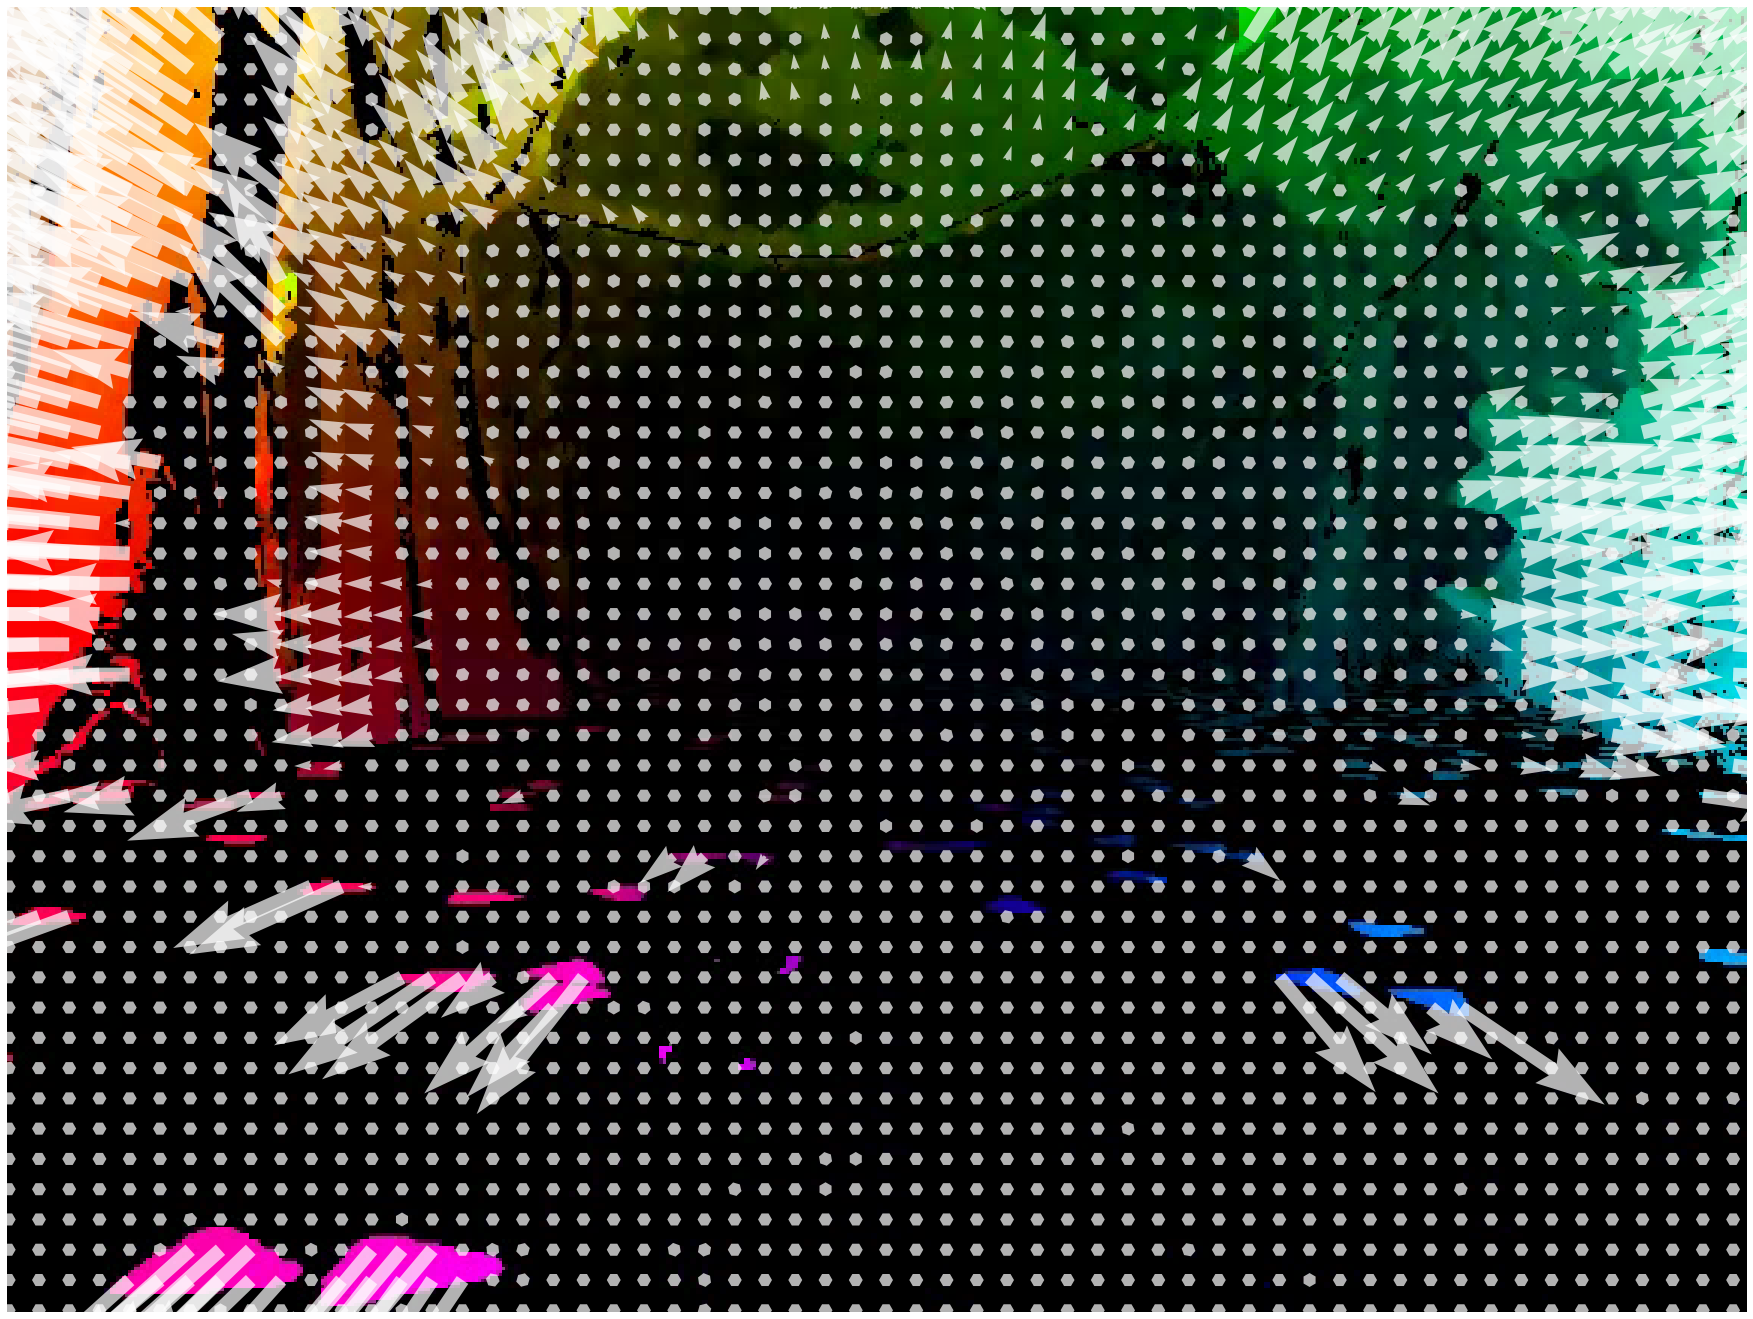

In [309]:
plt.rcParams['figure.figsize'] = [640/20., 480 /20.]
plot_flow_overlay(image,flow, .9,skippts=10)

(-0.5, 639.5, 479.5, -0.5)

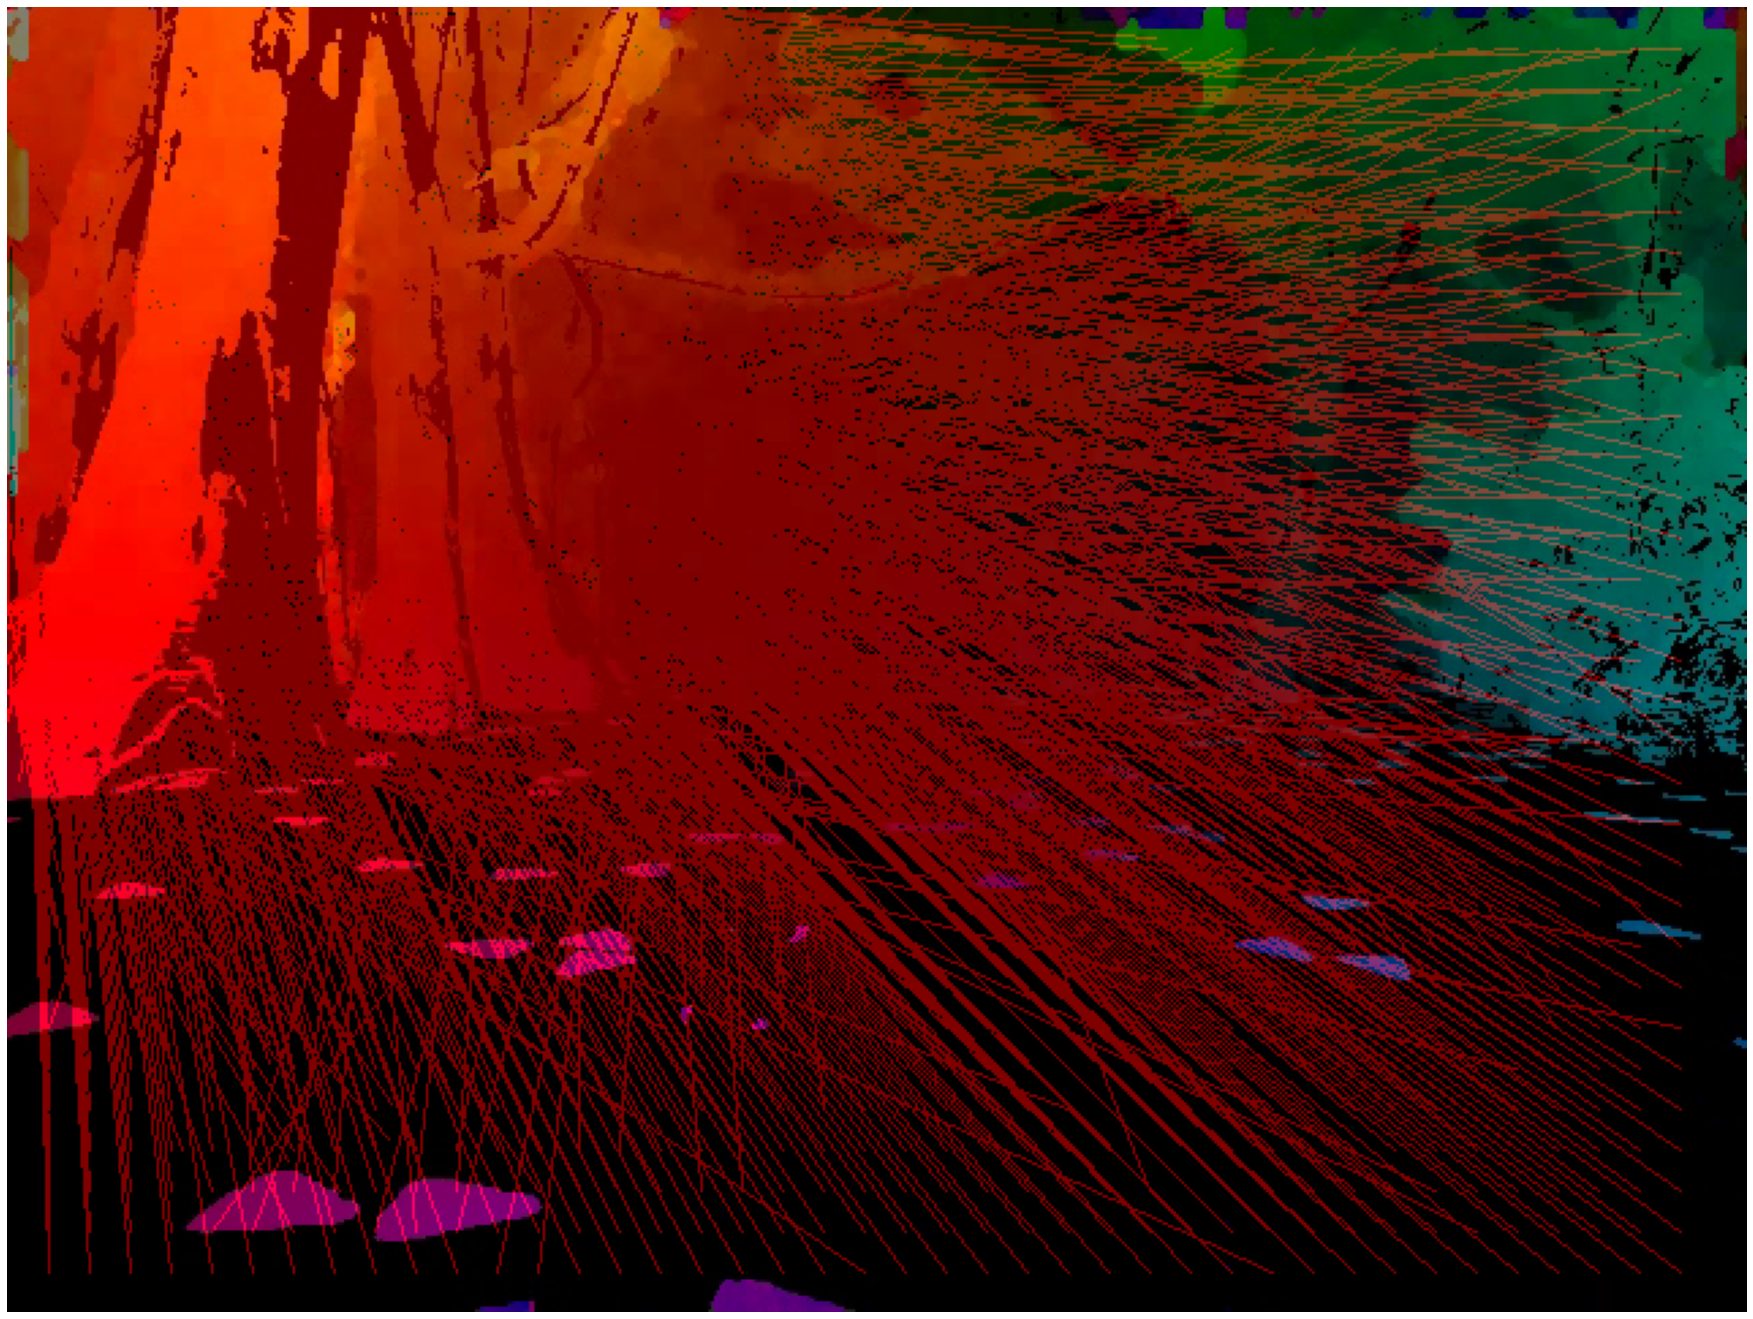

In [317]:
# plot_flow_overlay(image,flow, .9,skippts=10)
flow_im = visualize_flow_as_vectors(image, flow, 
                                    divisor=15, 
                                    vector_scalar = 1, 
                                    crop_to = 1.0,
                                    thickness = 1)

fig, ax = plt.subplots()
plt.imshow(cv2.cvtColor(flow_im, cv2.COLOR_BGR2RGB))
ax.axis('off') 


In [302]:
smoothed_flow = cv2.blur(combined_flow,[7,7])

In [303]:
source.file_path
rgb_vid = cv2.VideoCapture(source.file_path)
rgb_vid.set(cv2.CAP_PROP_POS_FRAMES, frame-1)
success, rgb_image = rgb_vid.read()

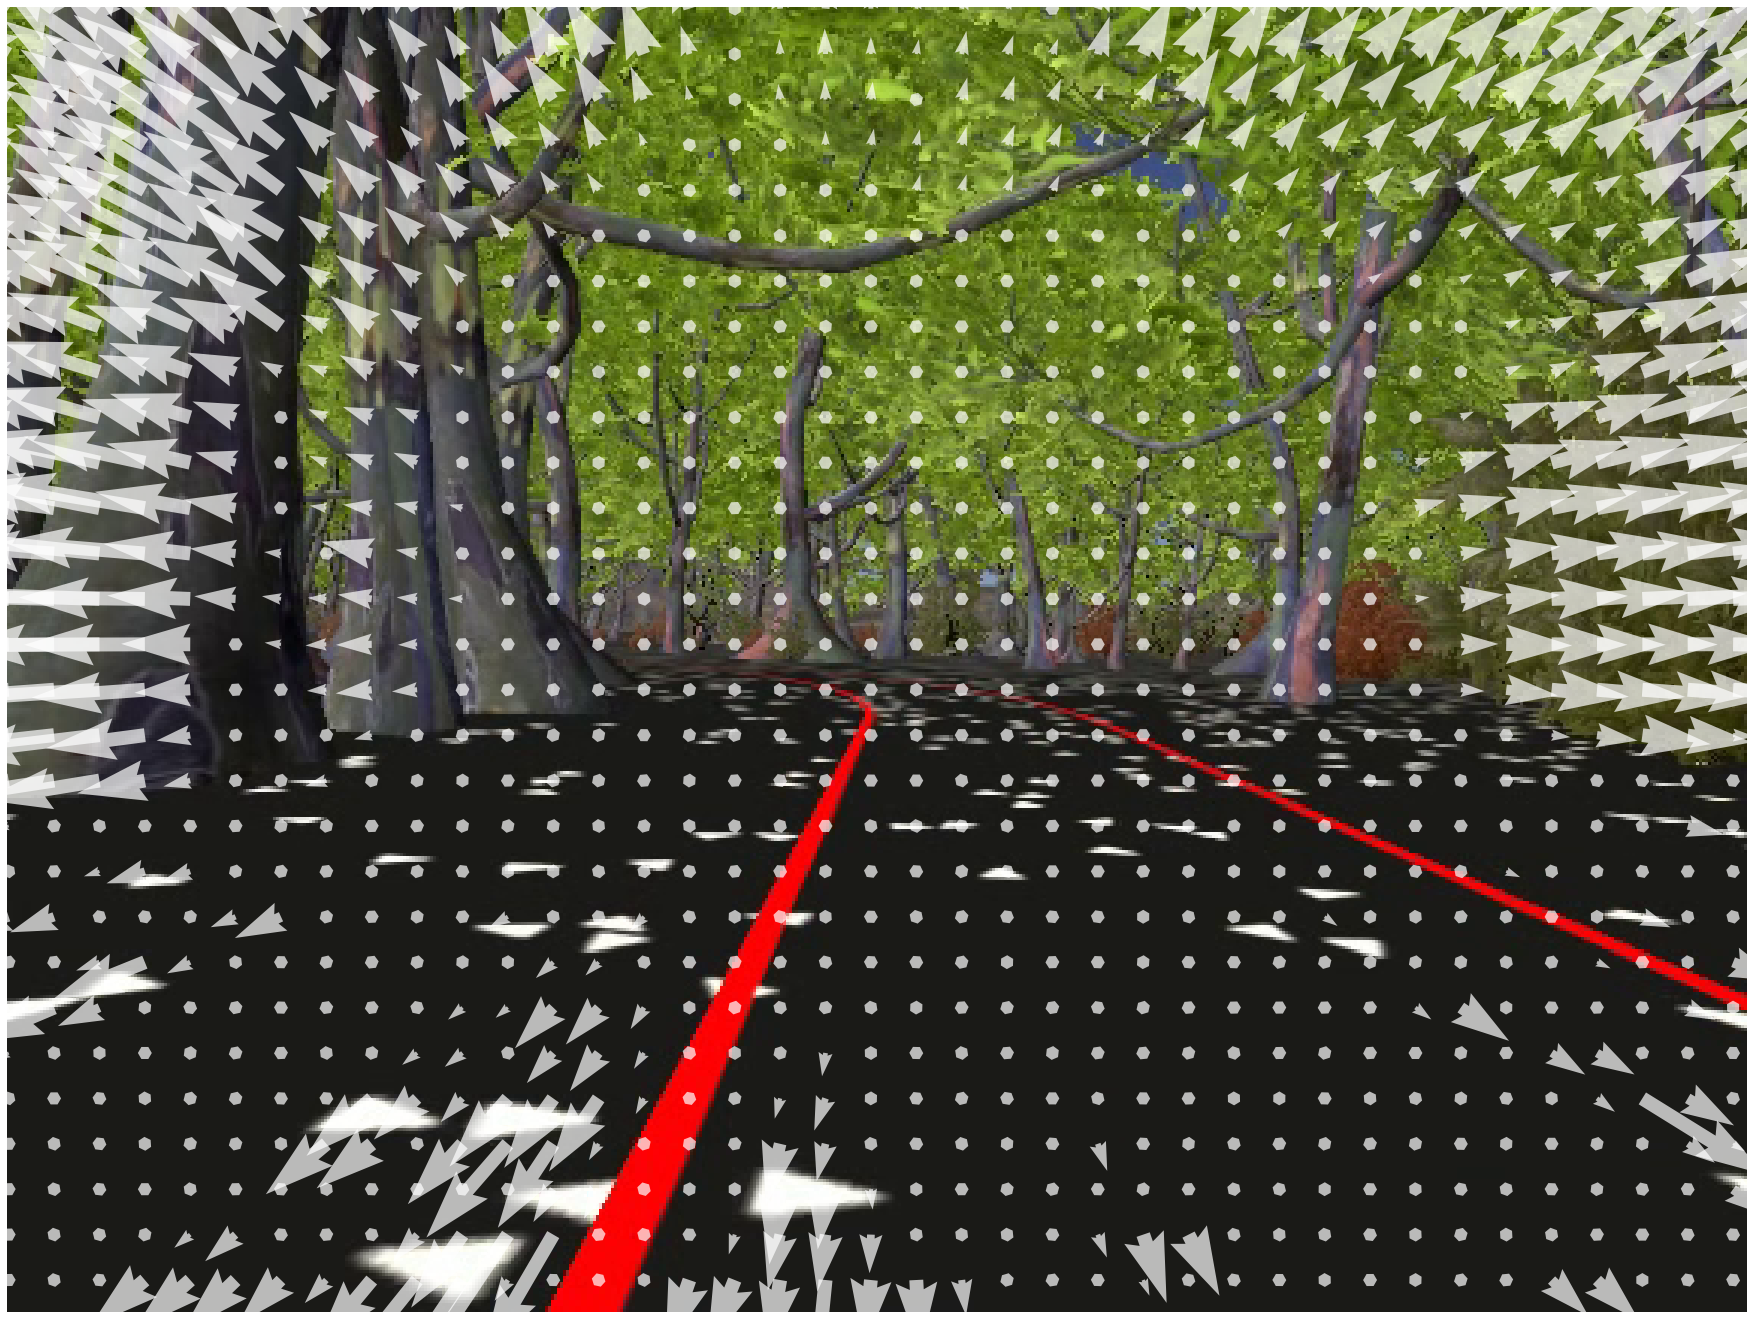

In [304]:
plt.rcParams['figure.figsize'] = [640/20., 480 /20.]
plot_flow_overlay(rgb_image,combined_flow, .9,skippts=15)

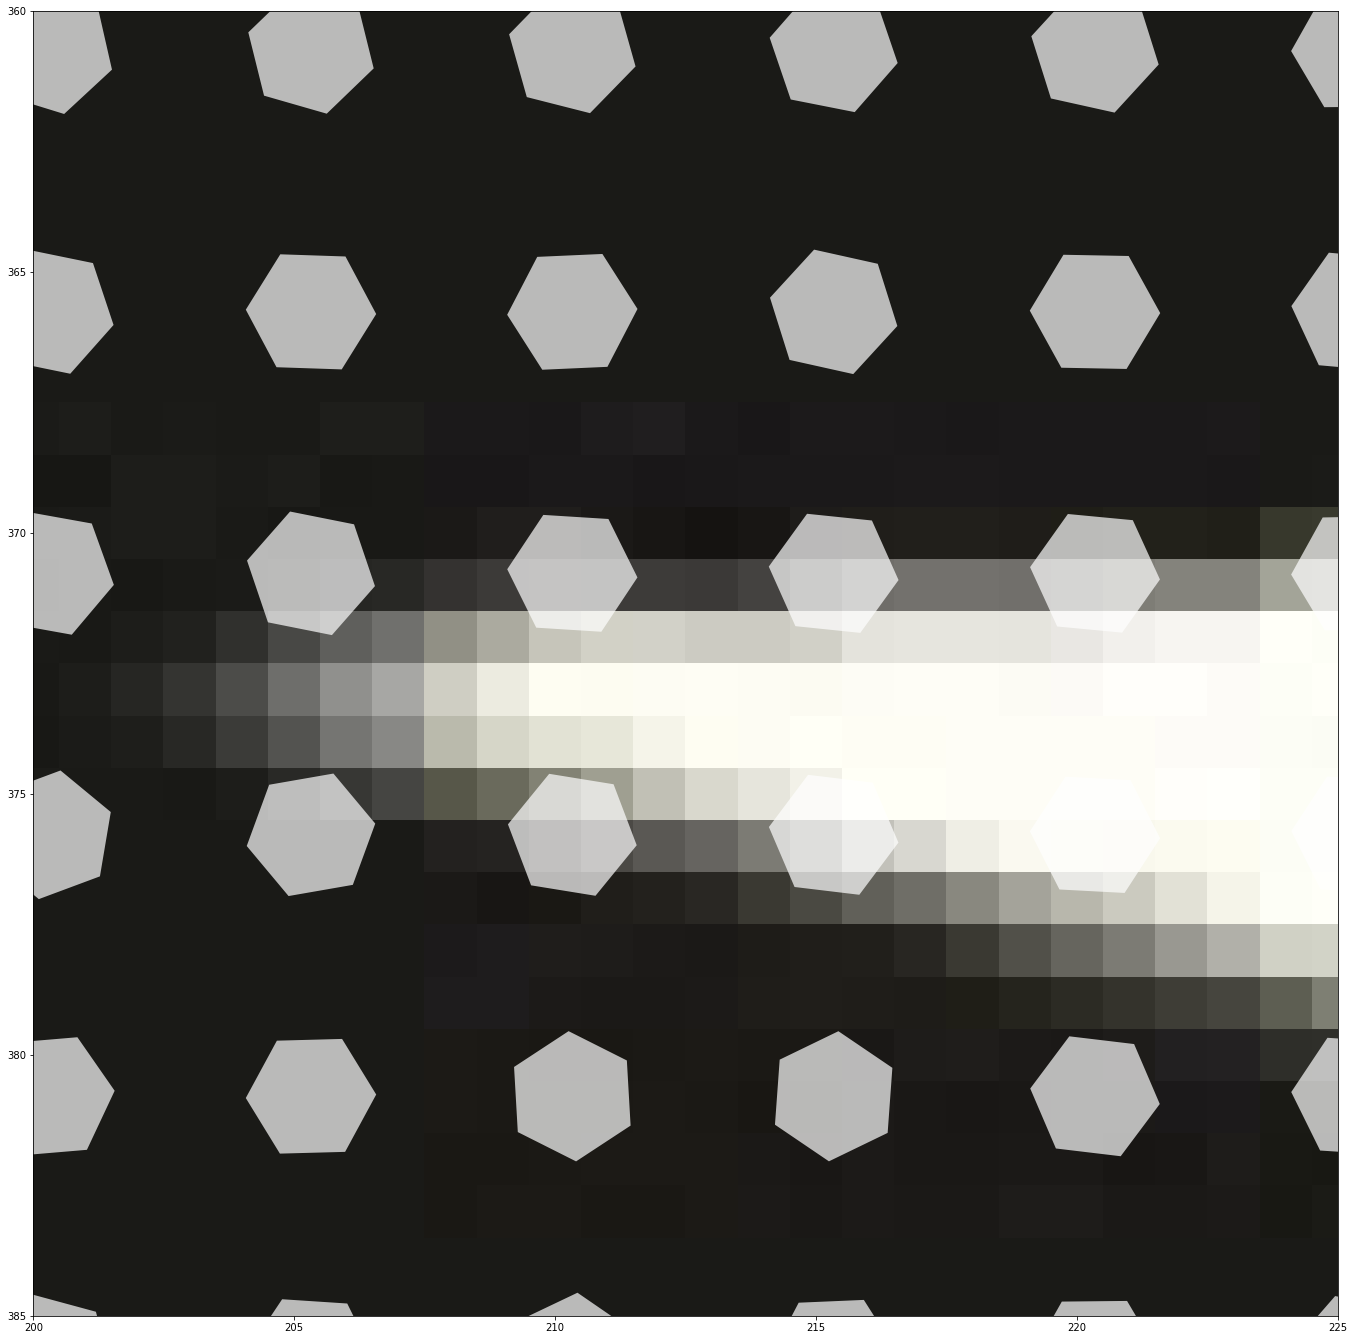

In [103]:
# def plot_flow_overlay_b(image_in, flow_in, crop_to=0.8, skippts=5):

image_in = rgb_image
flow_in = combined_flow
# crop_to = 0.8
skippts=5

# if crop_to:
#     image_in = crop_image(image_in,crop_to)
#     flow_in = crop_image(flow_in,crop_to)

xmax=np.shape(image_in)[1]
xpoints = int(np.shape(image_in)[1])
x=np.linspace(0,np.shape(image_in)[1],xmax)

ymax=np.shape(image_in)[0]
ypoints = int(np.shape(image_in)[0])
y=np.linspace(0,np.shape(image_in)[0],ymax)

x2d,y2d=np.meshgrid(x,y,indexing='xy')

u = flow_in[...,0]
v = flow_in[...,1]

#     plt.figure()
fig, ax = plt.subplots()
plt.imshow(cv2.cvtColor(image_in, cv2.COLOR_BGR2RGB))
# ax.axis('off') 

b = 0

ax.set_xlim([200, 225])
ax.set_ylim([385, 360])

# ax.set_xlim([ax.get_xlim()[0]-b, ax.get_xlim()[1]+b])
# ax.set_ylim([ax.get_ylim()[0]+b,ax.get_ylim()[1]-b])
# ax.set_ylim([-200,800])

if skippts:
    skip=(slice(None,None,skippts),slice(None,None,skippts)) #don't plot all the point as this get too messy
#         plt.quiver(x2d[skip], y2d[skip],u[skip],v[skip],color='white',alpha=0.5)
    plt.quiver(x2d[skip], y2d[skip],u[skip],v[skip],color='white', alpha=0.7, width=.1)
else:
    plt.quiver(x2d,y2d, u, v, color='white',alpha=0.5)



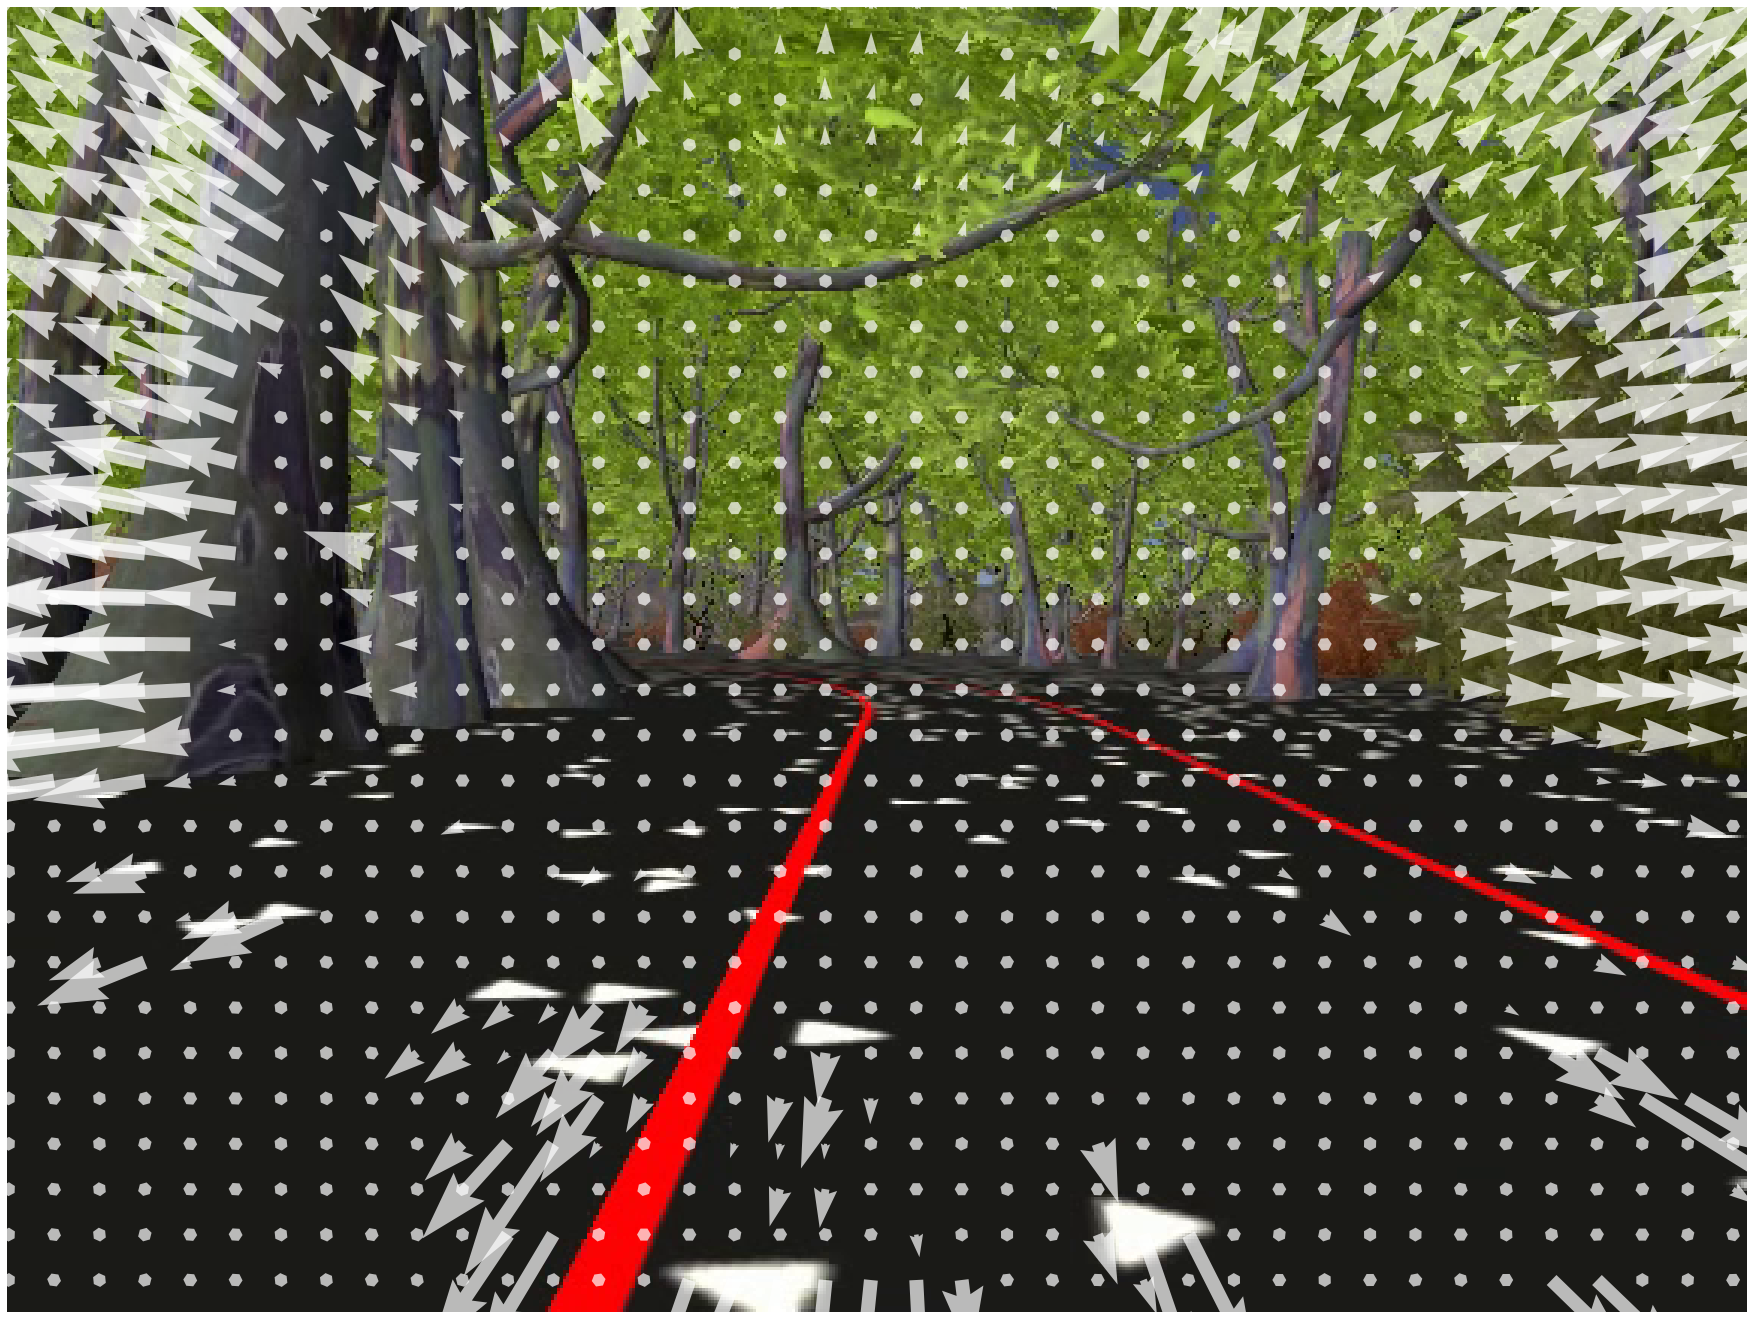

In [107]:
plt.rcParams['figure.figsize'] = [640/20., 480 /20.]
plot_flow_overlay(rgb_image,combined_flow, .9,skippts=15)

In [17]:
np.shape(image)[0] / np.shape(image)[1]

0.75

In [18]:
11 / .75

14.666666666666666

In [19]:
tiny_image = cv2.resize(image, [15,11])
tiny_flow = cv2.resize(smoothed_flow, [15,11])

In [20]:
np.shape(tiny_flow)

(11, 15, 2)

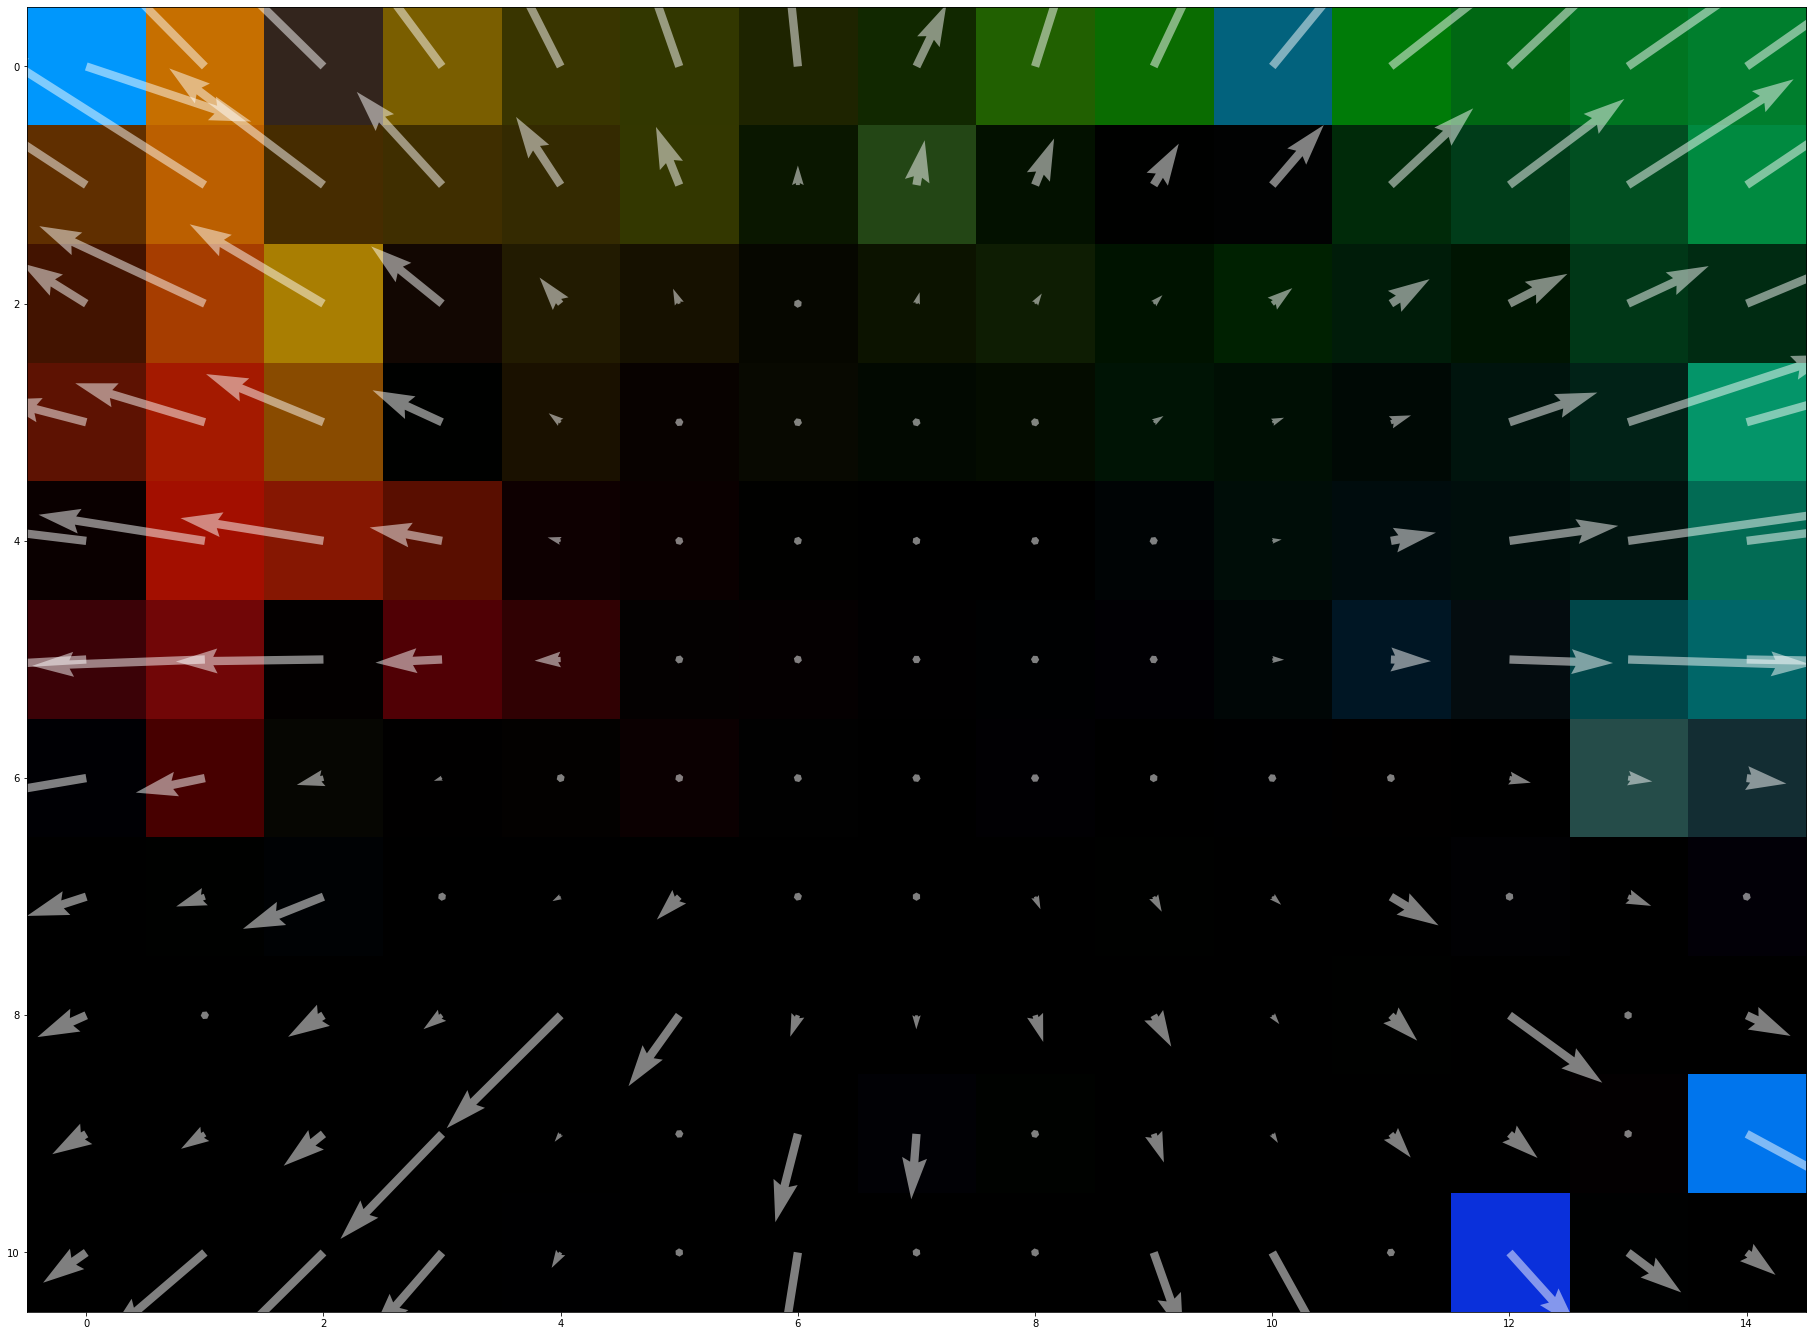

In [21]:
# plot_flow_overlay(tiny_image,tiny_flow,crop_to=False,skippts=False)

image_in = tiny_image
flow_in = tiny_flow

xmax = np.shape(image_in)[1]
xpoints = int(np.shape(image_in)[1])
x = np.linspace(0,np.shape(image_in)[1]-1,xmax)

ymax = np.shape(image_in)[0]
ypoints = int(np.shape(image_in)[0])
y=np.linspace(0,np.shape(image_in)[0]-1,ymax)

x2d,y2d=np.meshgrid(x,y,indexing='xy')

u = flow_in[...,0]
v = flow_in[...,1]

plt.figure()

plt.imshow(cv2.cvtColor(image_in, cv2.COLOR_BGR2RGB),origin='upper')
plt.quiver(x2d,y2d, u, v, color='white',alpha=0.5)

In [22]:
div, curl = calc_div_curl(tiny_flow)

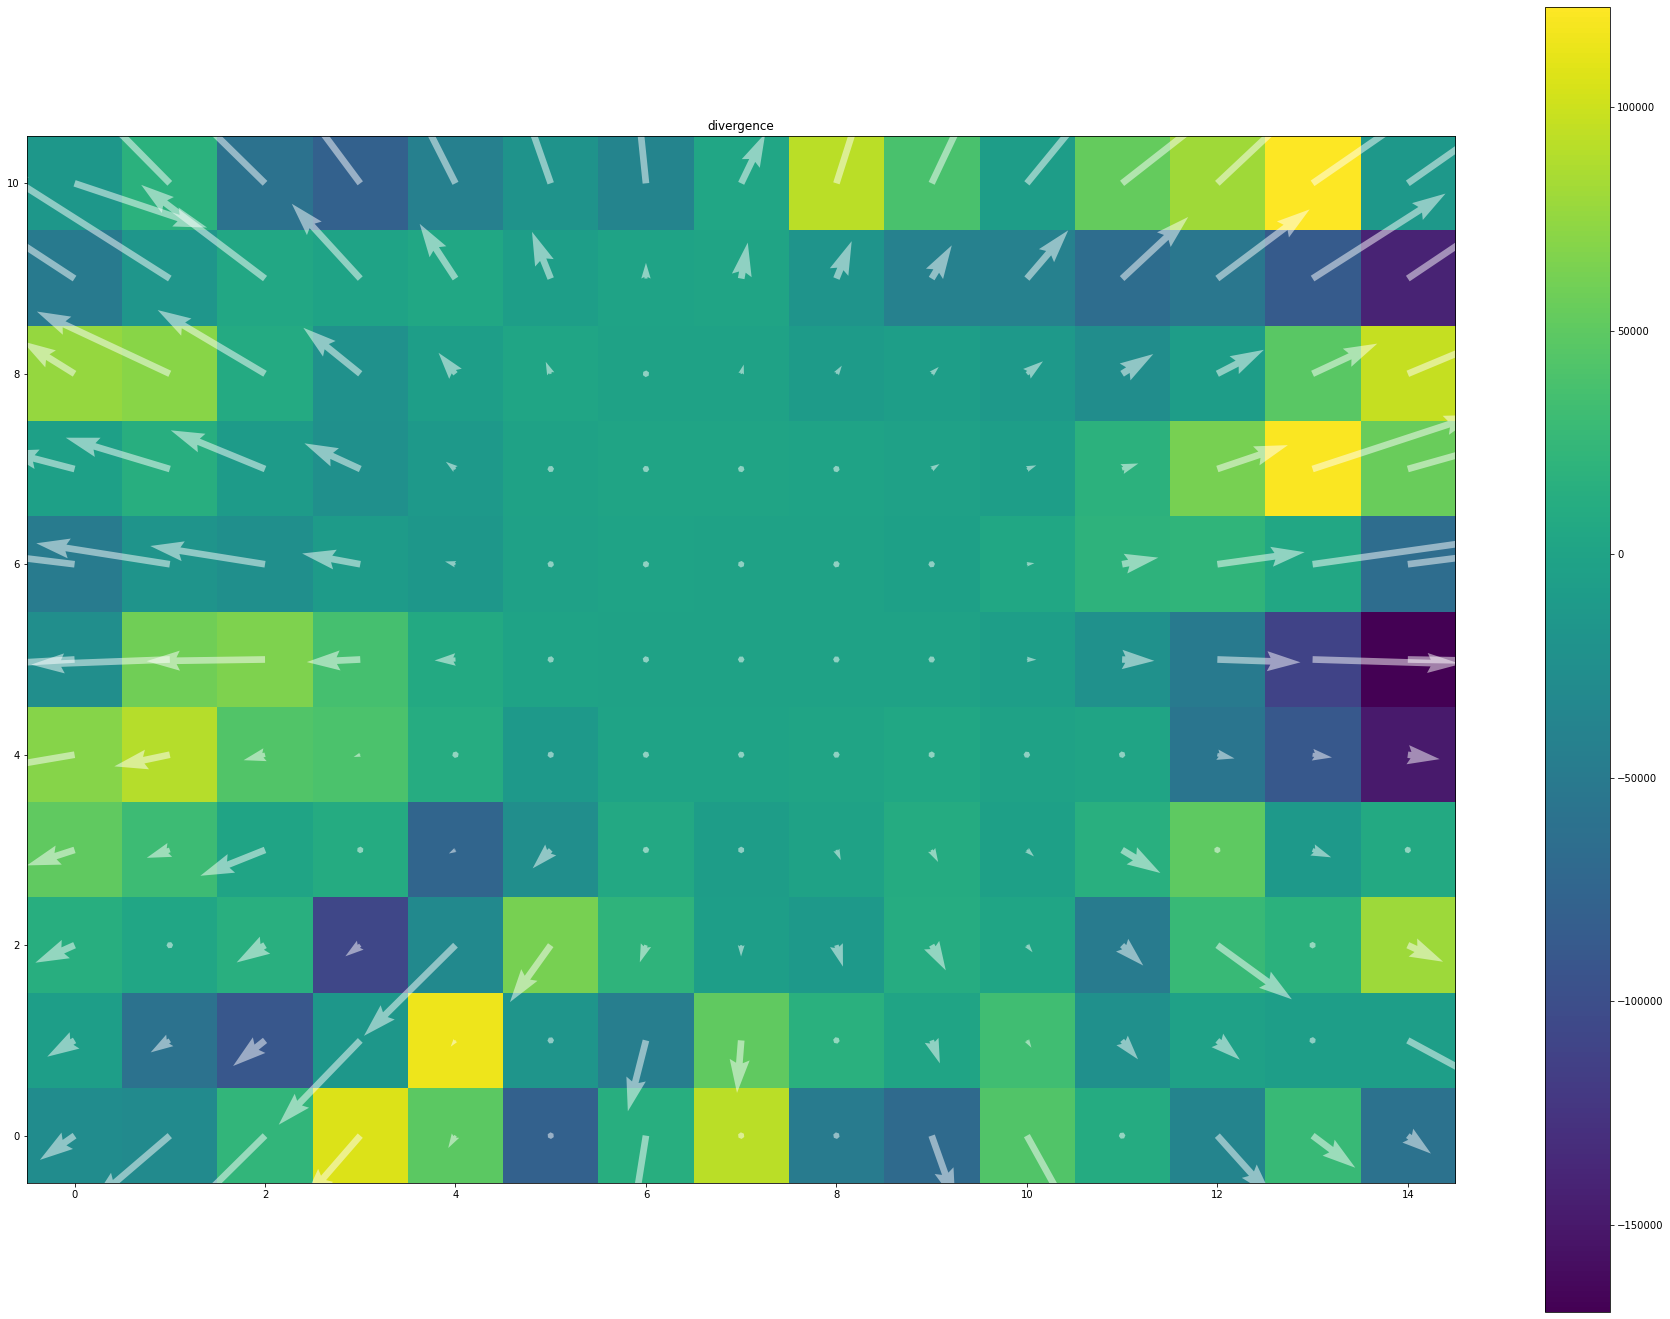

In [23]:
plt.figure()
plt.imshow(np.flipud(div),origin='lower')
plt.title('divergence')
plt.colorbar()
plt.quiver(x2d,len(y2d)-1-y2d, u, v, color='white',alpha=0.5)
plt.show()

In [24]:
div[int(np.ceil(np.shape(div)[0]/2)), int(np.ceil(np.shape(div)[1]/2))] 

1140.0122805704498

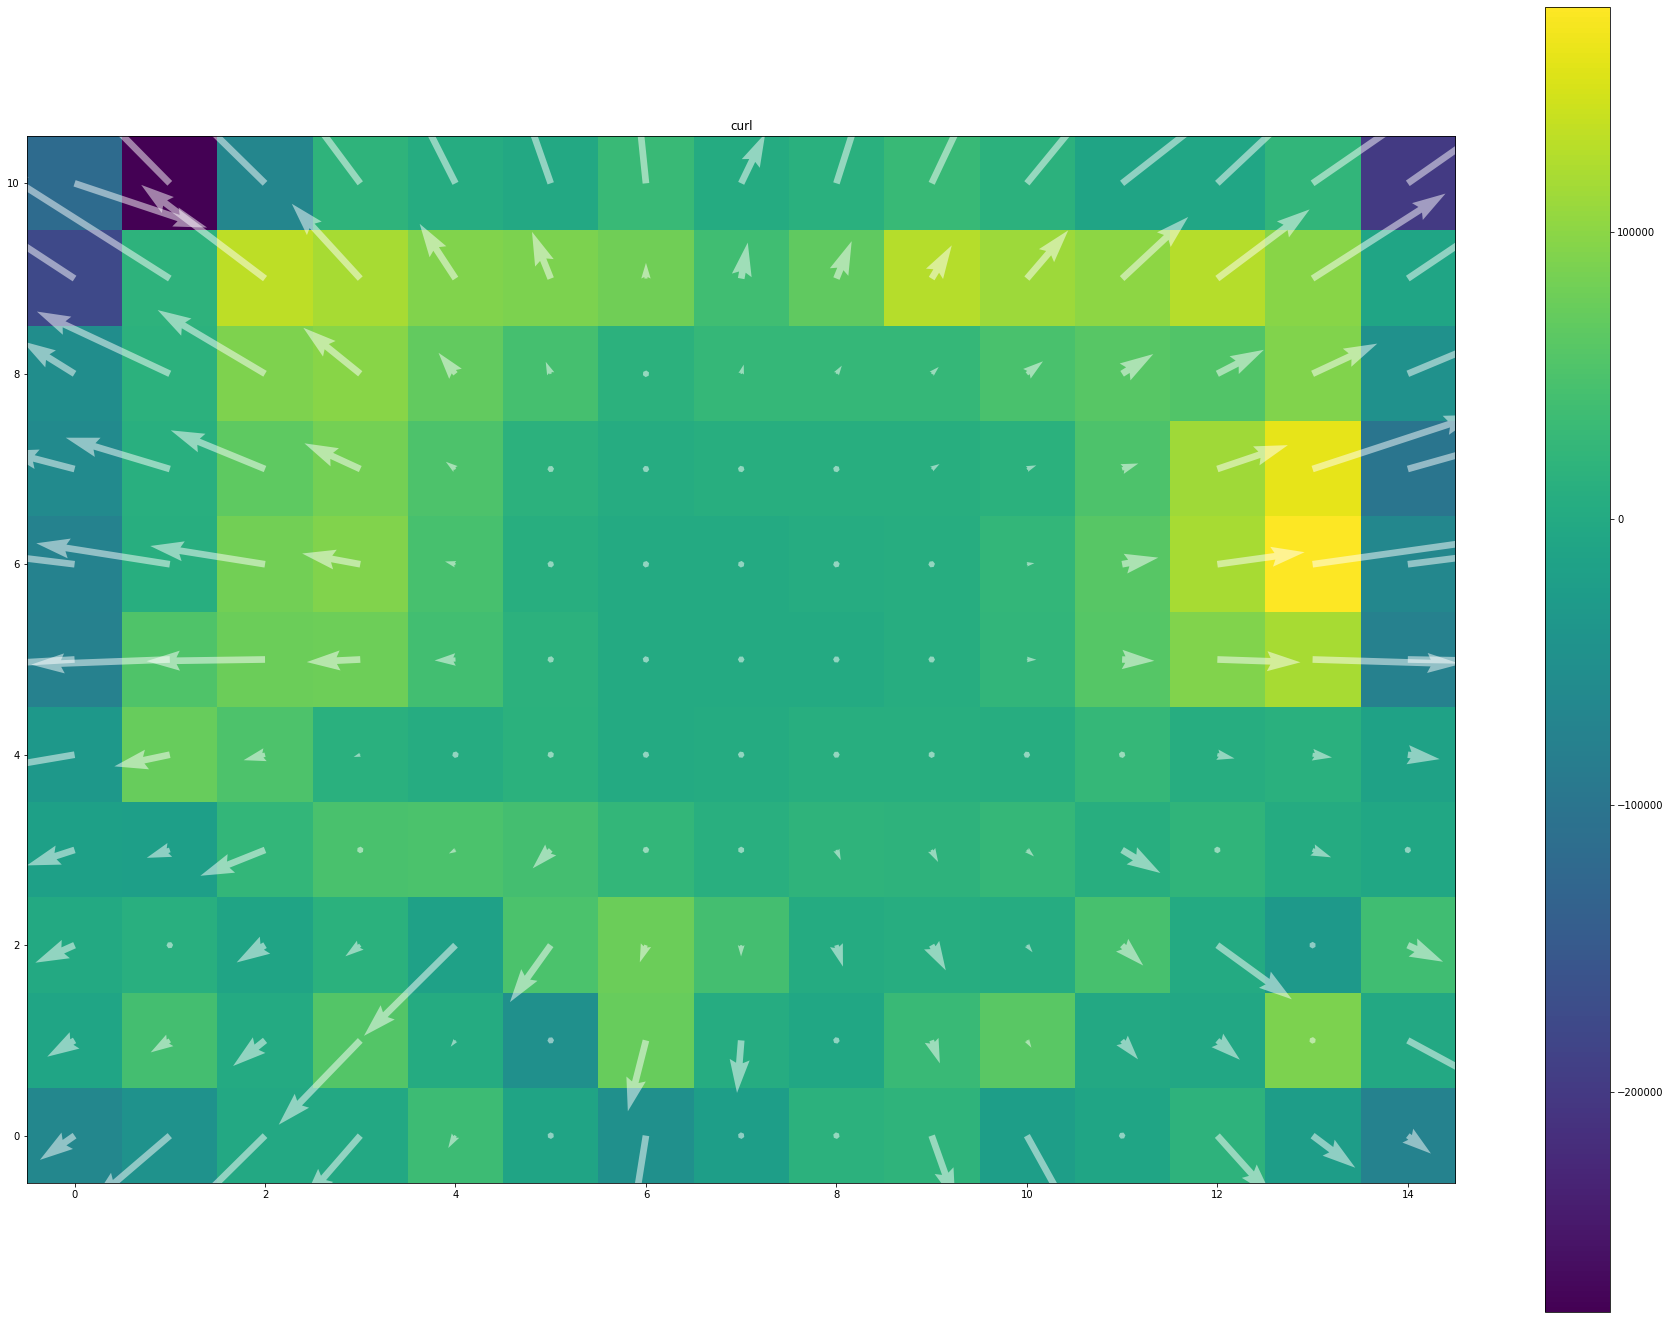

In [25]:
plt.figure()
plt.imshow(np.flipud(curl),origin='lower')
plt.title('curl')
plt.colorbar()
plt.quiver(x2d,len(y2d)-1-y2d, u, v, color='white',alpha=0.5)
plt.show()

# Time-series of div over the trial

In [26]:
# start_frame = 9023
# end_frame = 9432

# downsample_to = [15,11]

# div_time = []
# curl_time = []

# from collections import deque
# video.set(cv2.CAP_PROP_POS_FRAMES, start_frame)

# buffer_len = 20

# frame = 9023
# flow_buffer = deque([] * 30)

# success = True

# while success:
    
#     success, image = video.read()
    
#     if success:
        
#         hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
#         mag = hsv[...,2]
#         angle = (hsv[..., 0] * np.pi * 2.0) / 180.0 # angles are in radians here

#         u = mag * np.cos(angle) * mag * -1 # this is the same as flow[...,0] * mag * -1, as I did above
#         v = mag  * np.sin(angle) * mag
        
#         flow = np.zeros([np.shape(image)[0],np.shape(image)[1],2])
#         flow[...,0] = u
#         flow[...,1] = v
        
#         flow_buffer.appendleft(flow)
#         combined_flow = np.sum(flow_buffer,axis=0)
#         combined_flow = cv2.blur(combined_flow,[7,7])

#         tiny_flow = cv2.resize(combined_flow, downsample_to)
# #         tiny_flow = cv2.resize(cv2.blur(flow,[7,7]), downsample_to)
#         div, curl = calc_div_curl(tiny_flow)
        
#         div_time.append( div[int(np.ceil(np.shape(div)[0]/2)), int(np.ceil(np.shape(div)[1]/2))] ) 
#         curl_time.append( curl[int(np.ceil(np.shape(curl)[0]/2)), int(np.ceil(np.shape(curl)[1]/2))] ) 
#     else:
#         div_time.append(np.nan)
#         curl_time.append(np.nan)
        
#     frame = frame + 1
    
# #     if frame >= start_frame + buffer_len*2.0:
# #         success = False
        
# #     if frame >= end_frame:
# #         success = False

# # print(count)

In [27]:
# # 60 fps, roughly

# plt.subplots(figsize=[10,5])
# plt.plot(np.arange(len(div_time)) * (1/60), div_time,':o')
# plt.xlabel('time (s)')
# plt.ylabel('divergence')

In [28]:
# plt.subplots(figsize=[10,5])
# plt.plot(np.arange(len(curl_time)) * (1/60),curl_time,':o')
# plt.xlabel('frame')
# plt.ylabel('curl')

In [29]:
# # 60 fps, roughly

# plt.subplots(figsize=[10,5])
# plt.plot(np.arange(len(div_time)) * (1/60), div_time,':o')
# plt.xlabel('time (s)')
# plt.ylabel('divergence')